# PCA Analysis Breast Cancer

You are tasked with developing a machine learning model to classify breast cancer tumors as either benign (non-cancerous) or malignant (cancerous) based on features extracted from breast cancer biopsies.The dataset you will be working with is the Breast Cancer Wisconsin (Diagnostic) dataset, available in sklearn. This dataset contains a total of 569 instances with 30 feature attributes computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. The target variable is binary, with '0' indicating benign tumors and '1' indicating malignant tumors. 

To complete the task you need to: 

1. Principal Component Analysis (PCA) for dimensionality reduction and then train a classifier on the reduced dataset. Remember to train the chosen model on the PCA-transformed training data. 
2. Evaluate the model's performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) on the test dataset.
3. Visualize the results, such as the confusion matrix, to assess the model's performance in classifying benign and malignant tumors.
4. Summarize the findings and the effectiveness of PCA in reducing dimensionality for this classification task.

**Librerías**

In [83]:
# Standard library imports
import itertools
import math
import os
import sys
import time
import warnings
from collections import defaultdict

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd
from scipy import sparse as sp, stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.sparse.linalg import svds
from scipy.special import softmax
from scipy.stats import multivariate_normal

# Text and natural language processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine Learning and Data Science libraries
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, silhouette_samples, silhouette_score
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    rand_score,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Graph and plot libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cbook import boxplot_stats
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import plotly.express as px

# Deep Learning libraries
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset

# Transformer models
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Utility and other specific tools
from adjustText import adjust_text
from tabulate import tabulate
from tqdm.notebook import tqdm

# Recommender systems and specific utilities
import cornac
from cornac.data.text import BaseTokenizer
from cornac.data import GraphModality, ImageModality, TextModality, text as cornac_text
from cornac.datasets import amazon_clothing, filmtrust, movielens
from cornac.eval_methods import RatioSplit
from cornac.models import (
    BPR,
    BaselineOnly,
    CTR,
    ItemKNN,
    MF,
    NMF,
    PMF,
    SVD,
    SoRec,
    UserKNN,
    VBPR,
    WMF,
)
from cornac.utils import cache

# from cornac.datasets.python_splitters import python_random_split
# from cornac.models.cornac.cornac_utils import predict_ranking

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

# from recommenders.utils.timer import Timer
# from recommenders.datasets import movielens
# from recommenders.utils.notebook_utils import store_metadata
# from recommenders.models.recommenders.utils.constants import SEED
# from recommenders.datasets.python_splitters import python_random_split
# from recommenders.evaluation.python_evaluation import (
#    map,
#    ndcg_at_k,
#    precision_at_k,
#    recall_at_k,
# )

# Constants and configurations
SEED = 42
VERBOSE = False
pd.set_option("max_colwidth", 0)
%matplotlib inline

# Printing versions of libraries
print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"TensorFlow version: {tf.__version__}")

System version: 3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]
Cornac version: 2.1
TensorFlow version: 2.16.1


In [84]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import pandas as pd

dataset = load_breast_cancer()
X_data = dataset.data
Y_data = dataset.target

dfX = pd.DataFrame(X_data, columns=dataset.feature_names)
dfY = pd.DataFrame(Y_data, columns=["target"])

In [85]:
df = dfX.copy()
df["target"] = dfY

df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [86]:
X = dfX
y = dfY

X_train, X_test, y_train, y_tests = train_test_split(
    X, y, test_size=0.2, random_state=0
)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [87]:
from sklearn.metrics import root_mean_squared_error

X_rank = np.linalg.matrix_rank(X_train)
max_components = min(X_train.shape[0], X_train.shape[1]) - 1
Ks = list(
    range(1, max_components + 1)
)  # Ajustando dinámicamente el rango basado en el tamaño del conjunto de datos
# * - Distinta manera de obtenerlo
# L_linspace = np.linspace(1, X_rank, 10, dtype=int)

# ? - Vectors which are intended to store the RMSE values for train and test datasets.
RMSE_train = []
RMSE_test = []

for index, K in enumerate(Ks):
    pca = PCA(n_components=K)

    Xtrain_transformed = pca.fit_transform(X_train)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train.append(root_mean_squared_error(X_train, Xtrain_proj))

    Xtest_transformed = pca.transform(X_test)
    Xtest_proj = pca.inverse_transform(Xtest_transformed)
    RMSE_test.append(root_mean_squared_error(X_test, Xtest_proj))

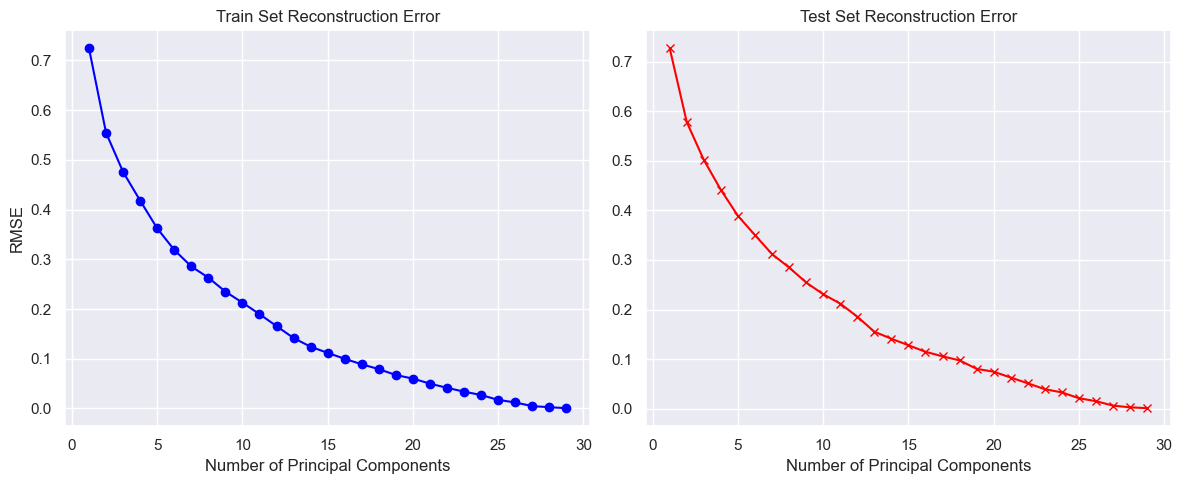

In [88]:
# * Plot train set reconstruction error vs. test set reconstruction error:
# Configurar la figura y los ejes para dos subplots: uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico para el conjunto de entrenamiento
axs[0].plot(Ks, RMSE_train, marker="o", color="blue")
axs[0].set_title("Train Set Reconstruction Error")
axs[0].set_xlabel("Number of Principal Components")
axs[0].set_ylabel("RMSE")

# Gráfico para el conjunto de prueba
axs[1].plot(Ks, RMSE_test, marker="x", color="red")
axs[1].set_title("Test Set Reconstruction Error")
axs[1].set_xlabel("Number of Principal Components")
# axs[1].set_ylabel("RMSE")  # Opcional, ya que comparten el mismo eje Y

plt.tight_layout()  # Ajustar automáticamente los parámetros de la subtrama para dar un relleno especificado
plt.show()

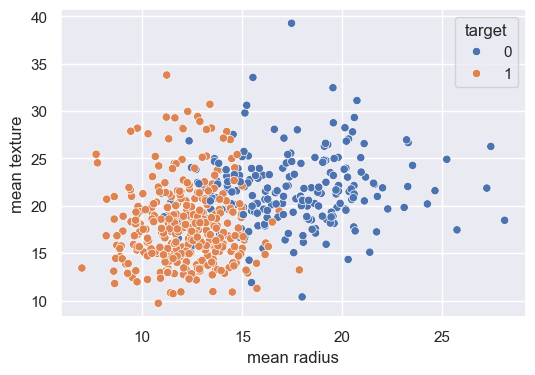

In [89]:
sns.set(rc={"figure.figsize": (6, 4)})
sns.scatterplot(df, x="mean radius", y="mean texture", hue="target");

In [90]:
X_std = StandardScaler().fit_transform(dfX)
X_rank = np.linalg.matrix_rank(np.cov(X_std))
X_rank

29

In [91]:
from sklearn.metrics import root_mean_squared_error

# Reconstruction error on MNIST vs number of latent dimensions used by PCA
# * This is dimension D
max_components = min(X_std.shape[0], X_std.shape[1]) - 1
Ks = list(
    range(1, max_components + 1)
)  # Ajustando dinámicamente el rango basado en el tamaño del conjunto de datos

# ? - Vectors which are intended to store the RMSE values for train and test datasets.
RMSE_train = []
RMSE_test = []

# * For each L which we want to test out perform a PCA and it's corresponding reconstruction
# * Both for the train & test datasets - Then for that specific L, log what the RMS error is in order to plot it.
for index, K in enumerate(Ks):

    pca = PCA(n_components=K)
    # Fit PCA on the training data and transform it
    Xtrain_transformed = pca.fit_transform(X_std)
    Xtrain_proj = pca.inverse_transform(Xtrain_transformed)
    RMSE_train.append(root_mean_squared_error(X_std, Xtrain_proj))

In [92]:
pca.components_.shape
eigenvalues = pca.explained_variance_
variance_explained = pca.explained_variance_ratio_
cumulative_variance_explained = pca.explained_variance_ratio_.cumsum()

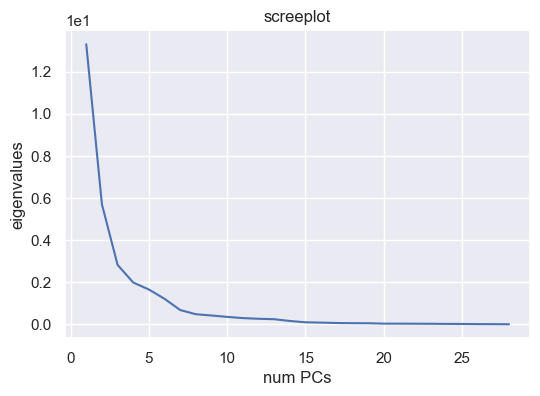

In [93]:
# * - Screeplot
fig, ax = plt.subplots()
xs = np.arange(1, len(eigenvalues))
ys = eigenvalues[0 : len(eigenvalues) - 1]
plt.title("screeplot")
plt.xlabel("num PCs")
plt.ylabel("eigenvalues")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.plot(xs, ys)
plt.show()

In [94]:
# * Profile Likelihood
def log_likelihood(evals):
    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):

        group1 = evals[0 : L + 1]  # Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        # eqn (20.30)
        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2
    return ll

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


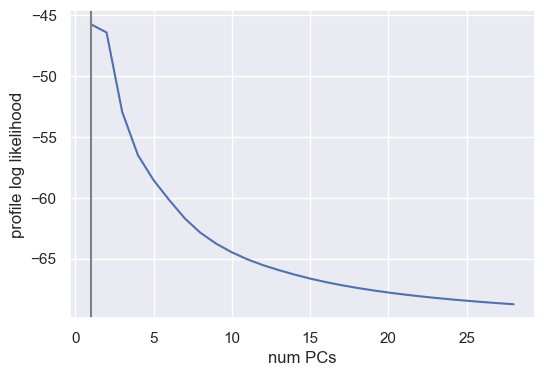

In [95]:
ll = log_likelihood(eigenvalues)  # * Insert all of the corresponding eigenvalues.

xs = np.arange(1, len(eigenvalues))
ys = ll[0 : len(eigenvalues) - 1]

plt.xlabel("num PCs")
plt.ylabel("profile log likelihood")
plt.plot(xs, ys)
idx = np.argmax(ys)
plt.axvline(xs[idx], c="grey")
plt.show()

Text(0.5, 1.0, 'Number of Latent dimensions: 6')

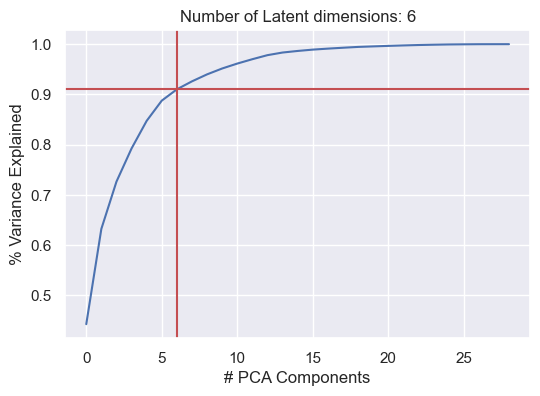

In [96]:
threshold = 0.9
idx = np.where(cumulative_variance_explained > threshold)[0][0]
exp_var = np.cumsum(pca.explained_variance_ratio_)

sns.lineplot(cumulative_variance_explained)
plt.axvline(idx, c="r")
plt.axhline(exp_var[idx], c="r")
plt.xlabel("# PCA Components")
plt.ylabel("% Variance Explained")
plt.title("Number of Latent dimensions: " + str(idx))

In [97]:
# Perform PCA
n_components = 6  #! - Definir observando la gráfica generada arriba
pca = PCA(n_components=n_components)
pca.fit(X_train)
X_transformed = pca.fit_transform(X_train)
evals = pca.explained_variance_  # eigenvalues in descending order
fraction_var = np.cumsum(
    evals[0:5] / np.sum(evals)
)  # ! - Change the dimension number to coincide with components

# Access the matrix W of eigenvectors (principal components)
W = pca.components_
print("Matrix W (Eigenvectors/Principal Components):")
print(W)

# Access the eigenvalues (explained variance)
eigenvalues = pca.explained_variance_
print("Eigenvalues (Explained Variance):")
print(eigenvalues)

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# * - Cum Sum
cum_variance_explained = pca.explained_variance_ratio_.cumsum()
print("Cumulative Variance:")
print(cum_variance_explained)

Matrix W (Eigenvectors/Principal Components):
[[ 2.21510355e-01  1.04505068e-01  2.29511887e-01  2.23652233e-01
   1.39944422e-01  2.41780959e-01  2.59991186e-01  2.63334563e-01
   1.32700158e-01  5.85035830e-02  2.06951338e-01  1.28497629e-02
   2.10076048e-01  2.03081143e-01  1.58805044e-02  1.65116311e-01
   1.41735276e-01  1.80733479e-01  3.36171320e-02  1.02907250e-01
   2.30248001e-01  1.05530572e-01  2.37482574e-01  2.27343206e-01
   1.29544674e-01  2.09471607e-01  2.29586612e-01  2.53097671e-01
   1.19741134e-01  1.30167524e-01]
 [-2.28496135e-01 -5.30408254e-02 -2.11983794e-01 -2.25785512e-01
   1.77473675e-01  1.47784815e-01  6.37919046e-02 -3.40805762e-02
   1.90562240e-01  3.61154066e-01 -1.08759064e-01  1.00969271e-01
  -1.00927941e-01 -1.51435815e-01  2.08455667e-01  2.38293326e-01
   2.09622144e-01  1.44298935e-01  1.82967703e-01  2.80604358e-01
  -2.15061389e-01 -3.43523191e-02 -1.99419417e-01 -2.14248037e-01
   1.71694351e-01  1.44708331e-01  1.06488848e-01 -1.89421876

In [98]:
feature_names = dfX.columns

n_features = pca.n_features_in_

loadings = pca.components_

pc_list = [f"PC{i}" for i in list(range(1, n_features))]
pc_loadings = dict(zip(pc_list, loadings))

loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df["feature_names"] = feature_names
loadings_df = loadings_df.set_index("feature_names")
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6
feature_names,,,,,,
mean radius,0.221510,-0.228496,-0.009681,-0.043489,0.036403,0.020614
mean texture,0.104505,-0.053041,0.048595,0.601706,-0.066681,0.014303
mean perimeter,0.229512,-0.211984,-0.010100,-0.043832,0.035549,0.016045
mean area,0.223652,-0.225786,0.031354,-0.049141,0.009320,0.000139
mean smoothness,0.139944,0.177474,-0.091275,-0.163243,-0.386833,-0.271500
mean compactness,0.241781,0.147785,-0.076975,-0.034269,0.002361,-0.033749
mean concavity,0.259991,0.063792,0.015561,-0.017084,0.093100,-0.029879
mean concave points,0.263335,-0.034081,-0.018094,-0.062882,-0.049273,-0.051502
mean symmetry,0.132700,0.190562,-0.027910,-0.093163,-0.272491,0.382359


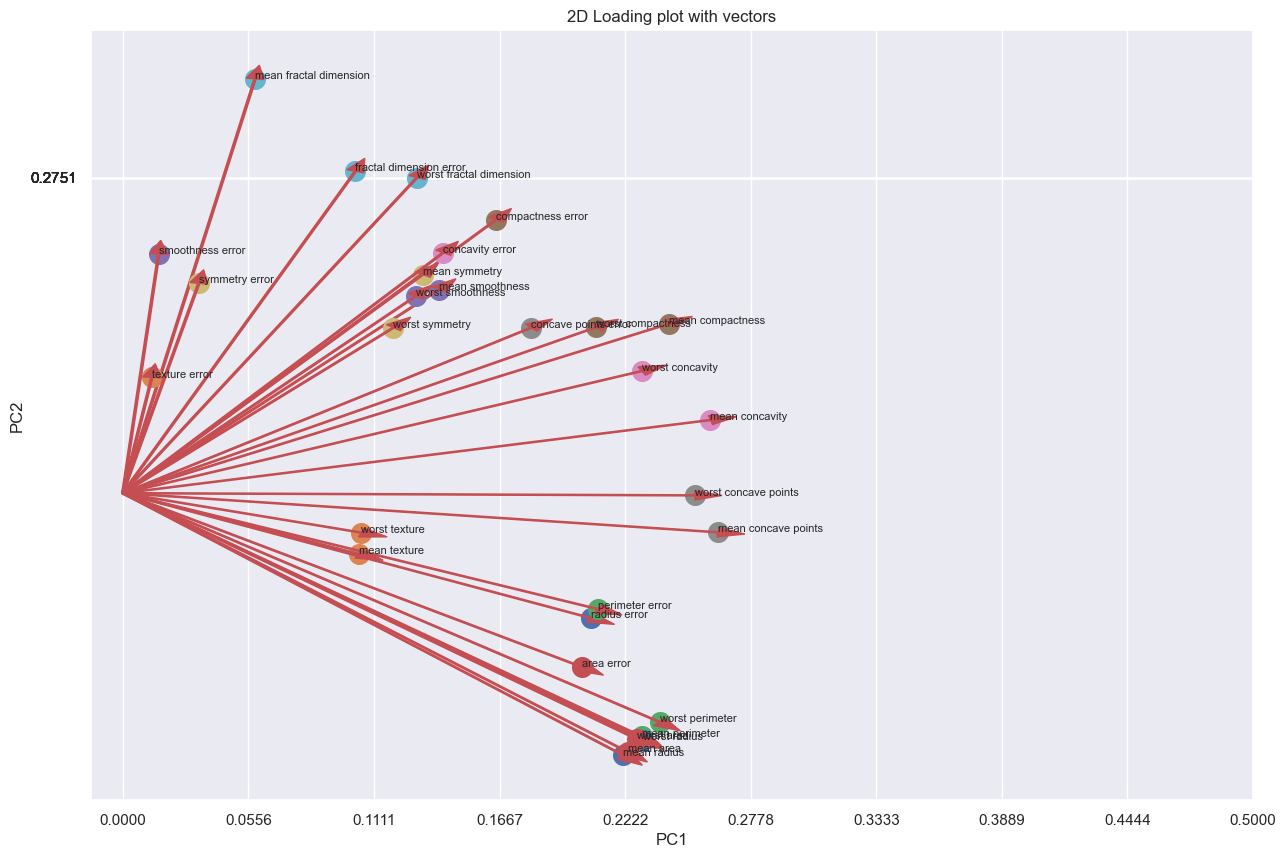

In [99]:
xs = loadings_df.iloc[:, 0]
ys = loadings_df.iloc[:, 1]

plt.figure(figsize=(15, 10))
# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs.iloc[i], ys.iloc[i], s=200)
    plt.arrow(
        0,
        0,  # coordinates of arrow base
        xs.iloc[i],  # length of the arrow along x
        ys.iloc[i],  # length of the arrow along y
        color="r",
        head_width=0.008,
    )
    plt.text(xs.iloc[i], ys.iloc[i], varnames, fontsize=8)

# Define the axes
ymin = np.min(ys.iloc[i])
ymax = np.max(ys.iloc[i])

xticks = np.linspace(0, 0.5, num=10)
yticks = np.linspace(ymin, ymax, num=10)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel("PC1")
plt.ylabel("PC2")

# Show plot
plt.title("2D Loading plot with vectors")
plt.show()

In [100]:
sorted_components = sorted(
    enumerate(variance_explained), key=lambda x: x[1], reverse=True
)
sorted_components

[(0, 0.44272025607526383),
 (1, 0.18971182044033064),
 (2, 0.09393163257431361),
 (3, 0.06602134915470156),
 (4, 0.05495768492346277),
 (5, 0.04024522039883344),
 (6, 0.02250733712982508),
 (7, 0.015887238000213275),
 (8, 0.013896493745591093),
 (9, 0.011689781894131496),
 (10, 0.00979718987598018),
 (11, 0.008705379007378831),
 (12, 0.008045249871967313),
 (13, 0.005233657454926348),
 (14, 0.0031378321676273947),
 (15, 0.0026620933651523163),
 (16, 0.0019799679253242734),
 (17, 0.0017539594502263619),
 (18, 0.0016492530592251682),
 (19, 0.0010386467483387016),
 (20, 0.000999096463700251),
 (21, 0.000914646751054346),
 (22, 0.0008113612588991058),
 (23, 0.0006018335666716714),
 (24, 0.0005160423791651867),
 (25, 0.00027258799547750075),
 (26, 0.00023001546250596454),
 (27, 5.297792903809431e-05),
 (28, 2.496010324687654e-05)]

### Then as an exercise try to apply some clustering

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay

In [102]:
# useful function that help us with the dataframes
def dataset_to_pandas(data, target):
    data = pd.DataFrame(data, columns=["X" + str(i + 1) for i in range(data.shape[1])])
    inputs = data.columns
    data["Y"] = target
    output = "Y"
    return data, inputs, output

In [103]:
data_std = StandardScaler().fit_transform(dataset.data)
XTR, XTS, YTR, YTS = train_test_split(
    data_std, dataset.target, test_size=0.2, random_state=1, stratify=dataset.target
)

In [104]:
# Perform PCA in all datasets
subspace_dim = 6
pca = PCA(subspace_dim)
XTR_pca = pca.fit_transform(XTR)  # * X Training
XTS_pca = pca.fit_transform(XTS)  # * X Test

In [105]:
accrcies = []

# Select the values of k
k_start = 2
k_stop = 50
k_step = 1

k_values = np.arange(start=k_start, stop=k_stop, step=k_step).astype("int")

# Loop through k values, fitting models and getting accuracies

train_data, train_inputs, train_outputs = dataset_to_pandas(XTR_pca, YTR)

for k in k_values:
    knn_pipe = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k)),
        ]
    )
    knn_pipe.fit(train_data[train_inputs], train_data[train_outputs])

    accrcies.append(knn_pipe.score(train_data[train_inputs], train_data[train_outputs]))

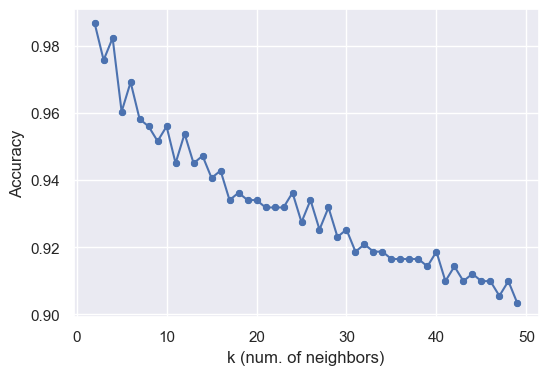

In [106]:
accrcies = np.array(accrcies)
# Plot accuracies vs k
ax_acc = sns.scatterplot(x=k_values, y=accrcies)
sns.lineplot(x=k_values, y=accrcies, ax=ax_acc)
ax_acc.set(xlabel="k (num. of neighbors)", ylabel="Accuracy");

* We need to find the best value of k for classification.
* We are going to create a pipeline that implements a grid search with 10-fold cross validation to try to estimate the optimal value of k in a KNN model for this dataset.
* We begin by defining the k values that we want to use. We will go from 3 to the training data size in 15 steps.

In [107]:
k_values = np.arange(1, 50)
hyp_grid = {"knn__n_neighbors": k_values}
knn_pipe_hyper = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())]
)

In [110]:
num_folds = 10

knn_gridCV = GridSearchCV(
    estimator=knn_pipe_hyper, param_grid=hyp_grid, cv=num_folds, return_train_score=True
)

knn_gridCV.fit(XTR_pca, YTR)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             return_train_score=True)

In [111]:
knn_gridCV.best_params_

{'knn__n_neighbors': 6}

In [112]:
knn_gridCV.score(XTR_pca, YTR), knn_gridCV.score(XTS_pca, YTS)

(0.9692307692307692, 0.8947368421052632)

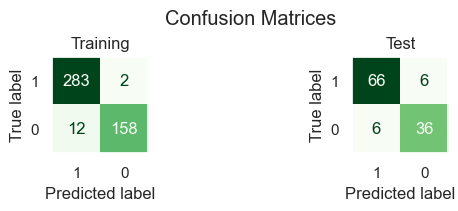

In [113]:
model = knn_gridCV
fig = plt.figure(constrained_layout=True, figsize=(6, 2))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title("Training")
ax1.grid(False)
ax3 = fig.add_subplot(spec[0, 1])
ax3.set_title("Test")
ax3.grid(False)
ConfusionMatrixDisplay.from_estimator(
    model, XTR_pca, YTR, cmap="Greens", colorbar=False, ax=ax1, labels=[1, 0]
)
ConfusionMatrixDisplay.from_estimator(
    model, XTS_pca, YTS, cmap="Greens", colorbar=False, ax=ax3, labels=[1, 0]
)
plt.suptitle("Confusion Matrices")
plt.show();

<Figure size 1200x1200 with 0 Axes>

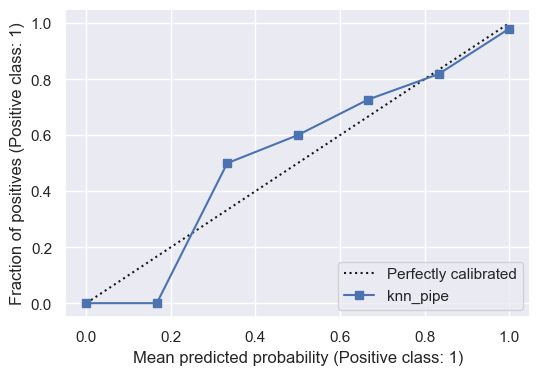

In [114]:
plt.figure(constrained_layout=False, figsize=(12, 12))
fig, ax = plt.subplots()
CalibrationDisplay.from_estimator(
    knn_gridCV, XTS_pca, YTS, n_bins=10, name="knn_pipe", pos_label=1, ax=ax
)

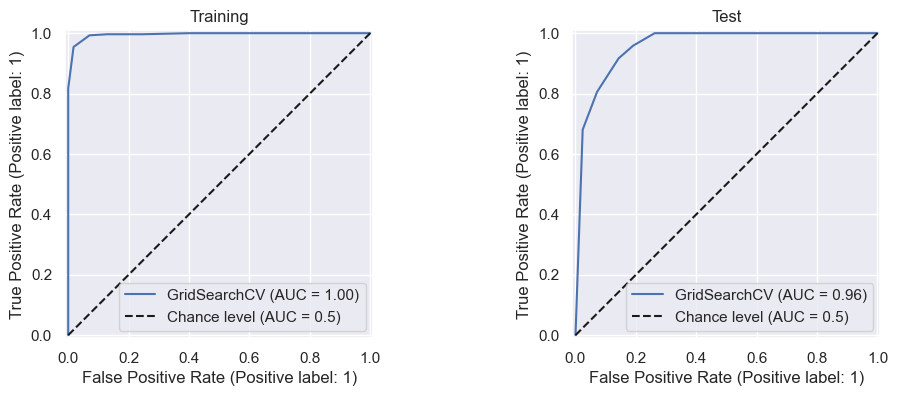

In [115]:
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title("Training")
ax2 = fig.add_subplot(spec[0, 1])
ax2.set_title("Test")
RocCurveDisplay.from_estimator(knn_gridCV, XTR_pca, YTR, plot_chance_level=True, ax=ax1)
RocCurveDisplay.from_estimator(knn_gridCV, XTS_pca, YTS, plot_chance_level=True, ax=ax2)
plt.show();